<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_08_19_swin_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swin Transformer

## Acknowledgment:
I borrowed some code from [Swin Transformer github repository](https://github.com/microsoft/Swin-Transformer/tree/main).

## References:
```bibtex
@inproceedings{liu2021Swin,
  title={Swin Transformer: Hierarchical Vision Transformer using Shifted Windows},
  author={Liu, Ze and Lin, Yutong and Cao, Yue and Hu, Han and Wei, Yixuan and Zhang, Zheng and Lin, Stephen and Guo, Baining},
  booktitle={Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV)},
  year={2021}
}
```

In [1]:
!pip install timm

## Import libraries

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

import torchvision
import torchvision.transforms as transforms

# tqdm
from tqdm.notebook import tqdm_notebook

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# Setting the seed for reproducibility
random.seed(42)
g = torch.Generator().manual_seed(2147483647)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

plt.style.use('dark_background')

Device: cuda:0


## Swin Transformer classes and helper functions
I copied these classes and functions from:


*   https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py
*   https://github.com/microsoft/Swin-Transformer/blob/main/models/build.py
*   https://github.com/microsoft/Swin-Transformer/blob/main/main.py


In [4]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [5]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [6]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [7]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [8]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 fused_window_process=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)
        self.fused_window_process = fused_window_process

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
                # partition windows
                x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
            else:
                x_windows = WindowProcess.apply(x, B, H, W, C, -self.shift_size, self.window_size)
        else:
            shifted_x = x
            # partition windows
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
                x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
            else:
                x = WindowProcessReverse.apply(attn_windows, B, H, W, C, self.shift_size, self.window_size)
        else:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [9]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [10]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 fused_window_process=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,
                                 fused_window_process=fused_window_process)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

In [11]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

In [12]:
class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, fused_window_process=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint,
                               fused_window_process=fused_window_process)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

## Initialize the model

In [13]:
model = SwinTransformer(img_size=32,
                          patch_size=2,
                          in_chans=3,
                          num_classes=10,
                          embed_dim=48,
                          depths=[2, 2, 6, 2],
                          num_heads=[3, 6, 12, 24],
                          window_size=4,
                          mlp_ratio=4,
                          qkv_bias=True,
                          qk_scale=None,
                          drop_rate=0.0,
                          drop_path_rate=0.1,
                          ape=False,
                          norm_layer=nn.LayerNorm,
                          patch_norm=True,
                          use_checkpoint=False,
                          fused_window_process=False)

# Transfer to GPU
model.to(device)
# setup the loss function
criterion = nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.AdamW(model.parameters(), lr=5e-4)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=48, input_resolution=(16, 16), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=48, input_resolution=(16, 16), num_heads=3, window_size=4, shift_size=0, mlp_ratio=4
          (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=48, window_size=(4, 4), num_heads=3
            (qkv): Linear(in_features=48, out_features=144, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=48, out_features=48, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm

## Import cifar10 dataset

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# set the preprocess operations to be performed on train/val/test samples
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download CIFAR10 training set and reserve 50000 for training
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [40000, 10000])

# download CIFAR10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:08<00:00, 20.6MB/s]


## Training

In [16]:
# Make sure gradient tracking is on, and do a pass over the data
model.train(True)
# Training loop
for epoch in range(200):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = criterion(preds, labels)
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

epoch 0:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 8:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 9:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 10:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 11:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 12:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 13:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 14:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 15:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 16:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 17:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 18:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 19:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 20:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 21:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 22:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 23:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 24:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 25:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 26:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 27:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 28:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 29:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 30:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 31:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 32:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 33:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 34:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 35:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 36:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 37:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 38:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 39:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 40:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 41:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 42:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 43:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 44:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 45:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 46:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 47:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 48:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 49:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 50:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 51:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 52:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 53:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 54:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 55:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 56:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 57:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 58:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 59:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 60:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 61:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 62:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 63:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 64:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 65:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 66:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 67:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 68:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 69:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 70:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 71:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 72:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 73:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 74:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 75:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 76:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 77:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 78:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 79:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 80:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 81:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 82:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 83:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 84:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 85:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 86:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 87:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 88:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 89:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 90:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 91:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 92:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 93:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 94:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 95:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 96:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 97:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 98:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 99:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 100:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 101:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 102:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 103:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 104:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 105:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 106:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 107:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 108:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 109:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 110:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 111:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 112:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 113:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 114:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 115:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 116:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 117:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 118:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 119:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 120:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 121:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 122:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 123:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 124:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 125:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 126:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 127:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 128:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 129:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 130:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 131:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 132:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 133:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 134:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 135:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 136:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 137:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 138:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 139:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 140:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 141:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 142:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 143:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 144:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 145:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 146:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 147:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 148:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 149:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 150:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 151:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 152:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 153:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 154:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 155:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 156:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 157:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 158:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 159:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 160:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 161:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 162:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 163:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 164:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 165:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 166:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 167:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 168:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 169:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 170:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 171:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 172:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 173:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 174:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 175:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 176:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 177:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 178:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 179:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 180:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 181:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 182:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 183:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 184:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 185:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 186:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 187:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 188:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 189:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 190:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 191:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 192:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 193:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 194:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 195:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 196:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 197:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 198:   0%|          | 0/312 [00:00<?, ?it/s]

epoch 199:   0%|          | 0/312 [00:00<?, ?it/s]

## Testing

In [ ]:
all_labels, all_pred_labels = [], []
model.eval()
acc_total = 0
with torch.inference_mode():
  for imgs, labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    all_labels.append(labels.data.tolist())
    all_pred_labels.append(pred_cls.data.tolist())
    acc_total += pred_cls.eq(labels.data).cpu().sum()

all_labels_flat = list(itertools.chain.from_iterable(all_labels))
all_pred_labels_flat = list(itertools.chain.from_iterable(all_pred_labels))

acc = acc_total.item()/len(test_loader.dataset)
print(f'Accuracy on test set = {acc*100:.2f}%')

Accuracy on test set = 70.07%


## Confusion matrix

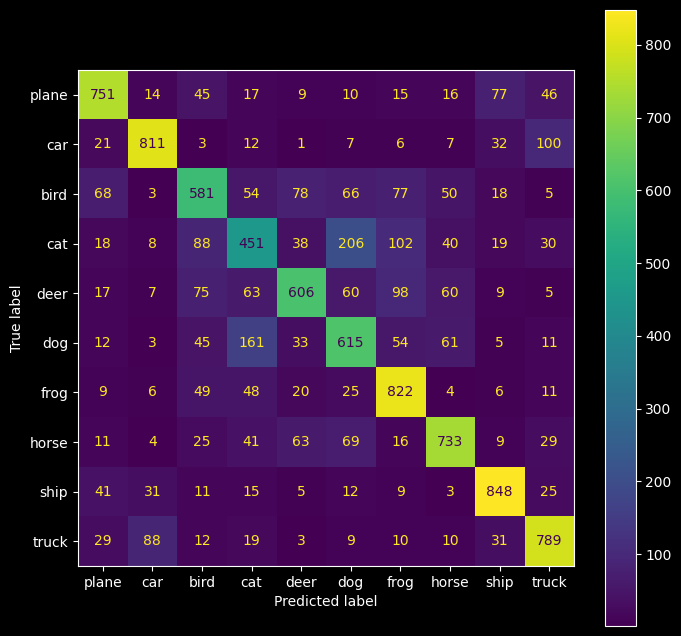

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(all_labels_flat, all_pred_labels_flat, display_labels=classes, ax=ax)
plt.show()